In [1]:
%pip install torchbnn
%pip install pytorch-lightning
%pip install tensorboard


[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pytorch_lightning as nnl # polars is pl
import matplotlib.pyplot as plt
import torchbnn as bnn
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np

import itertools
import warnings
import torch

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from copy import deepcopy
from IPython.display import Markdown

from wave_generator import WaveGen

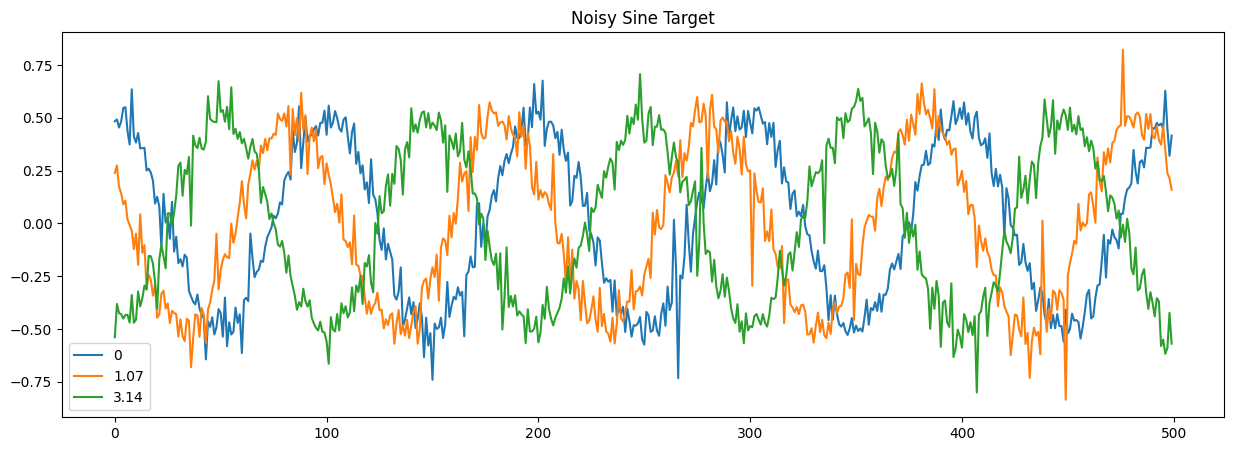

In [3]:
plt.figure(figsize=(15,5))
for phase in [0, 1.07, 3.14]:
    large_wave = WaveGen(size=500).linear_phase(phase).cos().amp(.5).t_noise(std=.05, dof=3).sample(1).samples.squeeze(axis=0)
    plt.plot(large_wave, label=str(phase))
plt.title('Noisy Sine Target')
plt.legend()
plt.show()

In [4]:
def create_composite_wave(phases, weights, size=5000):
    assert len(phases) == len(weights)
    assert sum(weights) == 1
    waves = list()
    for phase in phases:
        wave = WaveGen(size=size).linear_phase(phase).cos().amp(.5).t_noise(std=.05, dof=3).sample(1).samples.squeeze(axis=0)
        wave = np.diff(wave)
        waves.append(wave)
    input_wave = np.stack(waves, axis=1)
    target_wave = np.expand_dims(input_wave.dot(weights), axis=1)
    composite_wave = np.concatenate((input_wave, target_wave), axis=1)
    composite_wave = torch.from_numpy(composite_wave)
    return composite_wave

size = 5000
phases = [0.2, 1.07, 1.8, 2.45]
weights = [.1, .25, .35, .3]
composite_wave = create_composite_wave(phases, weights, size=size)

In [5]:
class SimpleDataset(Dataset):
    def __init__(self, Xy):
        self.X = Xy[:,:-1]
        self.y = Xy[:,-1].squeeze()
        return
        
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        X_sample = self.X[idx, :]
        y_sample = self.y[idx]
        return X_sample, y_sample

In [17]:
class LinearRegressor(nnl.LightningModule):
    def __init__(self, input_dim=None, output_dim=1, bias=True, bayesian=False, criterion=nn.MSELoss):
        super().__init__()
        self.c = criterion
        if input_dim:
            self.init_linear_layer(input_dim, output_dim=output_dim, bias=bias, bayesian=bayesian)
        else:
            self.output_dim = output_dim
            self.bias = bias
            self.bayesian = bayesian
        return
        
    def init_linear_layer(self, input_dim, output_dim=1, bias=True, bayesian=False):
        if bayesian:
            self.linear = bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma, in_features=input_dim, out_features=output_dim, bias=bias)
        else:
            self.linear = nn.Linear(input_dim, output_dim, bias=bias)
        return
            
    def forward(self, x):
        if not hasattr(self, 'linear'): # this allows input dimensions to be chosen on first run
            self.init_linear_layer(x.shape[1], output_dim=self.output_dim, bias=self.bias, bayesian=self.bayesian)
        x = self.linear(x).squeeze()
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self.forward(x)
        if not hasattr(self, 'criterion'):
            self.criterion = self.c(self.parameters())
        assert y_hat.shape == y.shape, f'{y_hat.shape} != {y.shape}'
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self.forward(x)
        if not hasattr(self, 'criterion'):
            self.criterion = self.c(self.parameters())
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return
    
    @property
    def coefficients(self):
        return self.linear.weight.squeeze()
    
    @property
    def intercept(self):
        return self.linear.bias

In [18]:
batch_size = 32
train_size = int(size * .8)
test_size = size - train_size - 1

composite_train = composite_wave[:train_size,:]
composite_val = composite_wave[train_size:]

train_loader = DataLoader(SimpleDataset(composite_train), batch_size=batch_size)
val_loader = DataLoader(SimpleDataset(composite_val), batch_size=batch_size)

model = LinearRegressor(input_dim=len(weights)).double()

trainer = nnl.Trainer(precision=16, max_epochs=100, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0., patience=5)])
trainer.fit(model, train_loader, val_loader)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5     
----------------------------------
5         Trainable params
0         Non-trainable params
5         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
display(Markdown('[Tensorboard](http://localhost:6006/#timeseries)'))
!tensorboard --logdir .

[Tensorboard](http://localhost:6006/#timeseries)